In [1]:
import warnings
warnings.filterwarnings('ignore')

# turn on plotting
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as mdates
#utilities for interacting with the OS
import os
import glob
import datetime
import netCDF4
import xarray
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
"""
pyart.retrieve.quasi_vertical_profile
=====================================

Retrieval of QVPs from a radar object

.. autosummary::
    :toctree: generated/

    quasi_vertical_profile

"""

import numpy as np

from pyart.core import antenna_to_cartesian



def quasi_vertical_profile(radar, fields = None, gatefilter = None):
    
    """
    Quasi Vertical Profile.
    
    Creates a QVP object ....
    
    
    Parameters
    ----------
    radar : Radar
        Radar object used.
    field : string
        Radar field to use for QVP calculation.
    
    Other Parameters
    ----------------
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the import qvp calculation
        
    Returns
    -------
    qvp : Dictonary
        Dictonary containing fields from radar object
    
    
    
    References
    ----------
    Troemel, S., M. Kumjian, A. Ryzhkov, and C. Simmer, 2013: Backscatter 
    differential phase – estimation and variability. J. Appl. Meteor. Clim.. 
    52, 2529 – 2548.

    Troemel, S., A. Ryzhkov, P. Zhang, and C. Simmer, 2014: Investigations 
    of backscatter differential phase in the melting layer. J. Appl. Meteorol. 
    Clim. 53, 2344 – 2359.

    Ryzhkov, A., P. Zhang, H. Reeves, M. Kumjian, T. Tschallener, S. Troemel, 
    C. Simmer, 2015: Quasi-vertical profiles – a new way to look at polarimetric 
    radar data. Submitted to J. Atmos. Oceanic Technol.
    
    """
    
    qvp = {}
    desired_angle = 20.0
    index = abs(radar.fixed_angle['data'] - desired_angle).argmin()
    print(radar.fixed_angle['data'])
    print(radar.elevation['data'][-1])
    
    radar_slice = radar.get_slice(index)
    
    if fields is None:
        fields = radar.fields

        for field in fields:
            if gatefilter is not None:
                this_field = radar.get_field(index, field)
                this_field = np.ma.masked_where(gatefilter.gate_excluded[s], 
                                                this_field)
                this_field = np.ma.mean(this_field, axis = 0)
            else: 
                this_field = radar.get_field(index, field).mean(axis = 0)
            qvp.update({field:this_field})

    else:
        if gatefilter is not None:
            this_field = radar.get_field(index, field)
            this_field = np.ma.masked_where(gatefilter.gate_excluded[s], 
                                            this_field)
            this_field = np.ma.mean(this_field, axis = 0)
        else: 
            this_field = radar.get_field(index, field).mean(axis = 0)
            
        qvp.update({fields:this_field})
        
    qvp.update({'range': radar.range['data'], 'time': radar.time})
    x,y,z = antenna_to_cartesian(qvp['range']/1000.0, 0.0, 
                                            radar.fixed_angle['data'][index])
    qvp.update({'height': z})
    del radar
    return qvp

In [ ]:
def run_qvp(radar_file_path):
    """For dask we need the radar plotting routines all in one subroutine"""
    try:
        radar = pyart.io.read(file)
    except OSError:
        continue
    radar_start_date = netCDF4.num2date(radar.time['data'][0], 
                                        radar.time['units'])
    time = datetime.datetime.strftime(radar_start_date, '%Y-%m-%dT%H:%M:%S')
    date = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    
    qvp = quasi_vertical_profile(radar)
    
    
    data = xarray.Dataset()
    data['time'] = time
    data['height'] = qvp['height']
    data['total_power']= qvp['total_power']
    data['reflectivity'] = qvp['reflectivity']
    data['velocity'] = qvp['velocity']
    data['spectrum_width'] = qvp['spectrum_width']
    data['differential_reflectivity'] = qvp['differential_reflectivity']
    data['specific_differential_phase'] = qvp['specific_differential_phase']
    data['cross_correlation_ratio'] = qvp['cross_correlation_ratio']
    data['normalized_soherent_power'] = qvp['normalized_coherent_power']
    data['differential_phase'] = qvp['differential_phase']
    data['xsapr_clutter'] = qvp['xsapr_clutter']
    data['sounding_temperature'] = qvp['sounding_temperature']
    data['SNR'] = qvp['SNR']
    data['velocity_texture'] = qvp['velocity_texture']
    data['gate_id'] = qvp['gate_id']
    data['corrected_velocity'] = qvp['corrected_velocity']
    data['unfolded_differential_phase'] = qvp['unfolded_differential_phase']
    data['filtered_corrected_differential_phase'] = qvp['filtered_corrected_differential_phase']
    data['corrected_differential_phase'] = qvp['corrected_differential_phase']
    data['corrected_specific_diff_phase'] = qvp['corrected_specific_diff_phase']
    data['filtered_corrected_specific_diff_phase'] = qvp['filtered_corrected_specific_diff_phase']
    data['specific_attenuation'] = qvp['specific_attenuation']
    data['attenuation_corrected_reflectivity'] = qvp['attenuation_corrected_reflectivity']
    data['rain_rate_A'] = qvp['rain_rate_A']
    
    data.to_netcdf('/home/jhemedinger/dev_pyart/qvp/qvps_out/qvp_' + str(time) + '.nc')
    data.close()
    del radar
    del qvp

    return

In [ ]:
radar_path = /lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004

In [3]:
files = glob.glob('/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/*')
files.sort()
print(files)

['/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.000019.nc', '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.001017.nc', '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.002015.nc', '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.003013.nc', '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.004012.nc', '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.005010.nc', '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.010008.nc', '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.011006.nc', '/lustre/or-hydra/cades-arm/proj-shared/sgpxsaprcmacsurI5.c1/20171004/sgpxsaprcmacsurI5.c1.20171004.012

In [4]:
tp = []
ref = []
vel = []
sw = []
zdr = []
kdp = []
rhv = []
ncp = []
dp = []
xclut = []
st = []
snr = []
vt = []
gid = []
cor_vel = []
u_dp = []
cor_dp = []
fil_dp = []
cor_kdp = []
fil_kdp = []
sa = []
acr = []
rr = []
rtime = []
hght = []

In [5]:
for file in files:
    try:
        radar = pyart.io.read(file)
    except OSError:
        continue
    radar_start_date = netCDF4.num2date(radar.time['data'][0], 
                                        radar.time['units'])
    time = datetime.datetime.strftime(radar_start_date, '%Y-%m-%dT%H:%M:%S')
    date = datetime.datetime.strftime(radar_start_date, '%Y%m%d')
    
    qvp = quasi_vertical_profile(radar)
    TP = qvp['total_power']
    REF = qvp['reflectivity']
    velocity = qvp['velocity']
    SW = qvp['spectrum_width']
    ZDR = qvp['differential_reflectivity']
    KDP = qvp['specific_differential_phase']
    RHV = qvp['cross_correlation_ratio']
    NCP = qvp['normalized_coherent_power']
    DP = qvp['differential_reflectivity']
    XCLUT = qvp['xsapr_clutter']
    ST = qvp['sounding_temperature']
    SNR = qvp['SNR']
    VT = qvp['velocity_texture']
    g_id = qvp['gate_id']
    COR_VEL = qvp['corrected_velocity']
    U_DP = qvp['unfolded_differential_phase']
    FIL_DP = qvp['filtered_corrected_differential_phase']
    COR_DP = qvp['corrected_differential_phase']
    COR_KDP = qvp['corrected_specific_diff_phase']
    FIL_KDP = qvp['filtered_corrected_specific_diff_phase']
    SA = qvp['specific_attenuation']
    ACR = qvp['attenuation_corrected_reflectivity']
    RR = qvp['rain_rate_A']
    height = qvp['height']
    #rtime = time
    
    tp.append(TP)
    ref.append(REF)
    vel.append(velocity)
    sw.append(SW)
    zdr.append(ZDR)
    kdp.append(KDP)
    rhv.append(RHV)
    ncp.append(NCP)
    dp.append(DP)
    xclut.append(XCLUT)
    st.append(ST)
    snr.append(SNR)
    vt.append(VT)
    gid.append(g_id)
    cor_vel.append(COR_VEL)
    u_dp.append(U_DP)
    fil_dp.append(FIL_DP)
    cor_dp.append(COR_DP)
    cor_kdp.append(COR_KDP)
    fil_kdp.append(FIL_KDP)
    sa.append(SA)
    acr.append(ACR)
    rr.append(RR)
    rtime.append(time)
    hght.append(height)
    
    del radar
    del qvp

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.94689
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.908447
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.92492
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93042
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.92492
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93591
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.94689
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.93591
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.941402
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    

[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.94964
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.952393
[ 0.49987793  0.99975586  1.4996338   2.4993896   3.4991455   4.4989014
  5.498657    6.498413    7.498169    8.497925    9.497681   10.497437
 11.502686   12.502441   14.002075   15.001831   17.001343   20.00061
 24.99939    29.998169   40.00122    49.99878    54.99756    60.00183   ]
59.957882


In [7]:
np.shape(hght)

(143, 501)

In [14]:
new_time = np.array(rtime, dtype='datetime64[ns]')
new_height = np.array(hght)
new_ref = np.array(ref)

In [18]:
new_ref.shape

(143, 501)

TypeError: Incompatible X, Y inputs to pcolormesh; see help(pcolormesh)

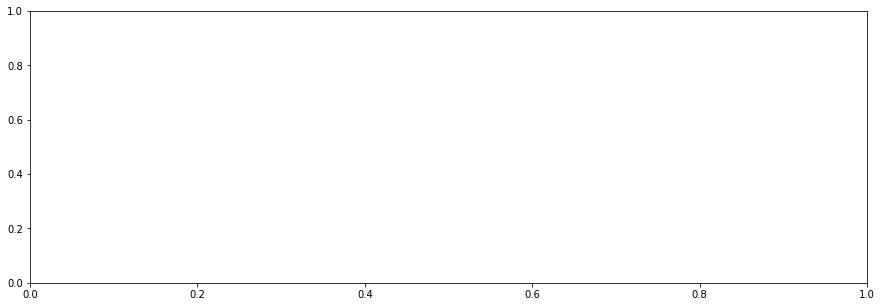

In [16]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_ref.transpose(), 
                     cmap=cmap, vmin=-20, vmax=64)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Reflectivity QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Reflectivity factor (dBZ)')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_dr.transpose(), 
                     cmap=cmap, vmin=-0.5, vmax=3)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Differential Reflectivity QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Differential Reflectivity factor (dBZ)')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_sq.transpose(), 
                     cmap=cmap)#, vmin=-0.5, vmax=3)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Spectrum Width QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Spectral Width (ms$^{-1}$)')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_phv.transpose(), 
                     cmap=cmap, vmin=0.8, vmax=1)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Cross Correlation Ratio QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Correlation Coefficent')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_kdp.transpose(), 
                     cmap=cmap)#, vmin=0.5, vmax=1)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Specific Differential Phase QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Specific Differntial Phase')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()

In [ ]:
fig = plt.figure(figsize=[15,5])
ax = plt.gca()
#ax.xaxis_date()
cmap = pyart.graph.cm_colorblind.HomeyerRainbow
#for i in range(10):
    #Xq, Yq = np.meshgrid(new_time[i], new_height/1000)
    
    
img = plt.pcolormesh(new_time, new_height/1000, new_dp.transpose(), 
                     cmap=cmap)#, vmin=0.5, vmax=1)
plt.xlabel('Time (UTC)')
plt.ylabel('Height (km)')
#plt.ylim([0,17.5])
plt.xticks(rotation=45)
plt.title('Differential Phase QVP')
cb = plt.colorbar(img, cmap=cmap)
cb.set_label('Mean Differntial Phase')
#plt.savefig('reflectivity.png', dpi=300)
plt.show()